### Task Details

This dataset is designed to understand the factors that lead to a person to work for a different company(leaving current job), by model(s) that uses the current credentials/demographics/experience to predict the probability of a candidate to look for a new job or will work for the company.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import missingno as msno

In [2]:
train = pd.read_csv('aug_train.csv')
test = pd.read_csv('aug_test.csv')
train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


### Description of each column:
- enrollee_id : Unique ID for candidate
- city: City code
- city_development_index : Developement index of the city (scaled)
- gender: Gender of candidate
- relevent_experience: Relevant experience of candidate
- enrolled_university: Type of University course enrolled if any
- education_level: Education level of candidate
- major_discipline :Education major discipline of candidate
- experience: Candidate total experience in years
- company_size: No of employees in current employer's company
- company_type : Type of current employer
- lastnewjob: Difference in years between previous job and current job
- training_hours: training hours completed
- target: 0 – Not looking for job change, 1 – Looking for a job change

#### Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality. 

In [3]:
display(train.info())
print(train.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

None

(19158, 14)


- The dataset has 19,158 observations and 14 attributes, and there is missing data as well

<AxesSubplot:>

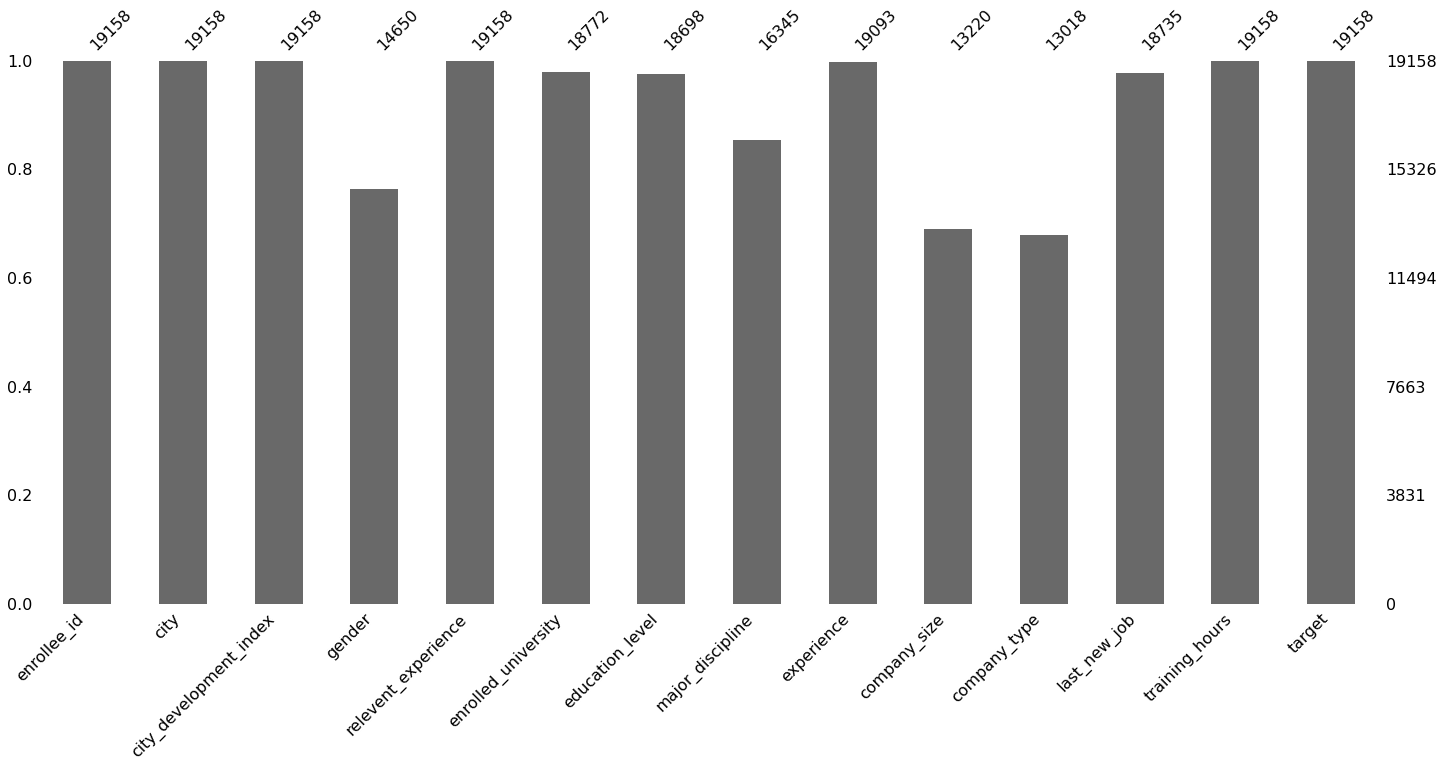

In [4]:
msno.bar(train)

- Gender, major_discipline, company_size, company_type have a lot of missing data and we'll have to take care of that. There are other columns with less missing data, and we'll take a closer look at these as well.

In [5]:
train.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

#### Quick note:  We will be using XGBoost for classification which can handle missing data

### Exploring the data further

In [6]:
cat_cols =['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level','major_discipline', 
           'experience', 'company_size', 'company_type','last_new_job'] 
for i in cat_cols:
    print(i + str(train[i].unique()) + ', ' + '# of Values:' + str(train[i].nunique()))

city['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_39' 'city_79' 'city_76'
 'city_77' 'city_81' 'city_131' 'city_44' 'city_

#### Looking at the different categorical attributes, and what their unique values are and how many each one has:
- city: 123
- gender: 3
- relevant_experience: 2
- enrolled_univeristy: 3
- education_level: 5
- major_discipline: 6
- experience: 22
- company_size: 8
- company_type: 6
- last_new_job: 6

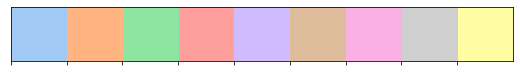

In [7]:
palette = sns.color_palette('pastel')[0:9]
sns.palplot(palette)

In [8]:
plt.style.use('seaborn-poster')
plt.style.use('ggplot')

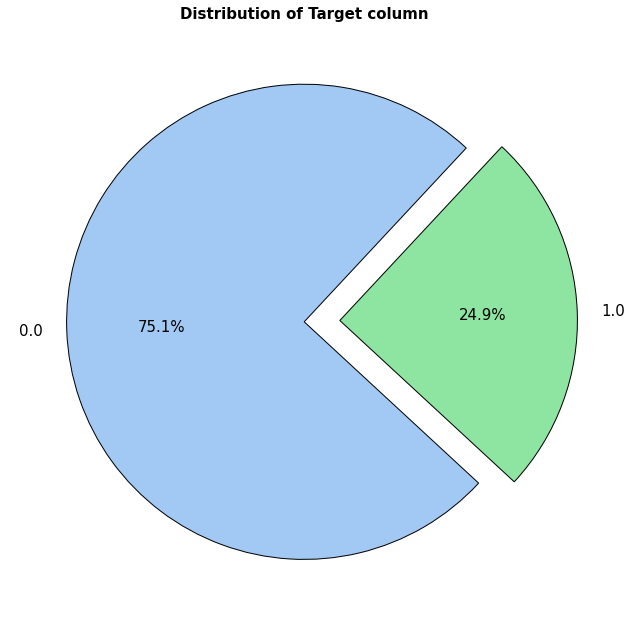

In [9]:
plt.pie(train['target'].value_counts().values, labels = train['target'].value_counts().index, autopct = '%1.1f%%',
        explode = [0,0.15], colors = [palette[0],palette[2]],startangle=47, textprops={'fontsize':15},
        wedgeprops={'edgecolor':'black','linewidth':1})
plt.title('Distribution of Target column', fontsize = 15,fontweight='bold')
plt.tight_layout()

#### Important to note that our target is imbalanced

In [10]:
train[['city_development_index','training_hours']].describe()

,city_development_index,training_hours
count,19158.000000,19158.000000
mean,0.828848,65.366896
std,0.123362,60.058462
min,0.448000,1.000000
25%,0.740000,23.000000
50%,0.903000,47.000000
75%,0.920000,88.000000
max,0.949000,336.000000


- These are both continuous features that are of different scale, we will use standard scaler later to ensure they have the same scale

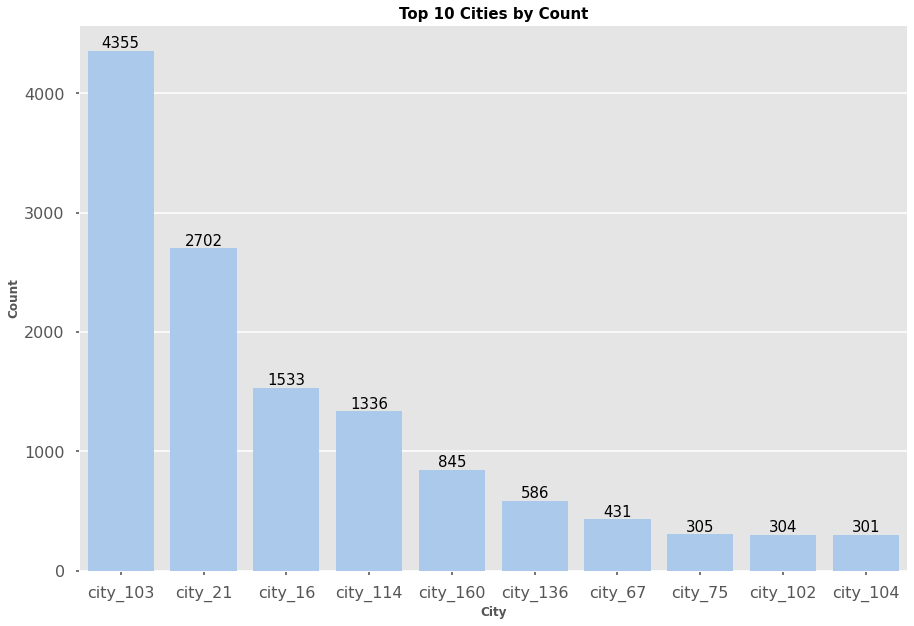

In [11]:
top10_cities = sns.barplot(data=train,x=train['city'].value_counts()[0:10].index,y=train['city'].value_counts()[0:10],
                     color=palette[0])
for p in top10_cities.patches:
        top10_cities.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=15,color= 'black')
plt.xlabel('City',fontsize=12,fontweight='bold')
plt.ylabel('Count',fontsize=12,fontweight='bold')
plt.title('Top 10 Cities by Count',fontsize=15,fontweight='bold')
plt.tight_layout()

In [12]:
def get_ct_graph(x,orientation = None,fontsize=15):
    ct = pd.crosstab(index=train[x],columns=train['target']).sort_values(by=1.0,ascending=False)
    num_bars = len(ct.index)
    graph = ct.plot.bar(stacked=False,color=[palette[0],palette[2]])
    for p in graph.patches:
        graph.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+p.get_width()/2, p.get_height()),
                    ha='center', va='bottom', fontsize=fontsize,color= 'black',rotation = orientation)
    plt.xlabel(x,fontsize=12,fontweight='bold')
    plt.xticks(rotation=25)
    plt.ylabel('Count',fontsize=12,fontweight='bold')
    plt.title('The Effect of ' + x +  ' on Changing Jobs',fontsize=15,fontweight='bold')
    plt.tight_layout()

#### Function to get grouped bar plots of the counts of the different categorical features (that dont have too many unique values, i.e. not including the city feature) in relation to changing jobs

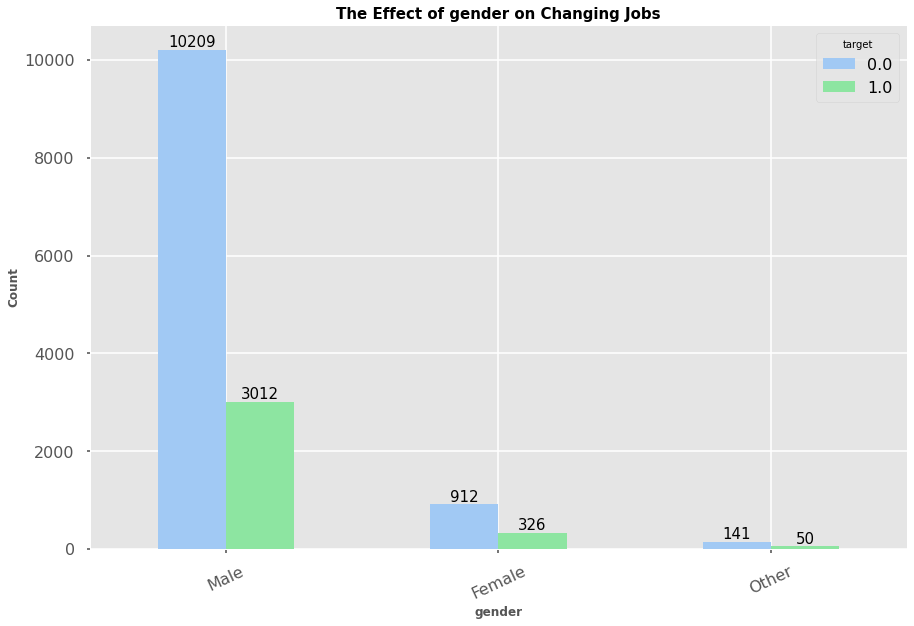

In [13]:
get_ct_graph('gender')

- Most job changes are done by men (this is by percentage of all men and total number of all workers)

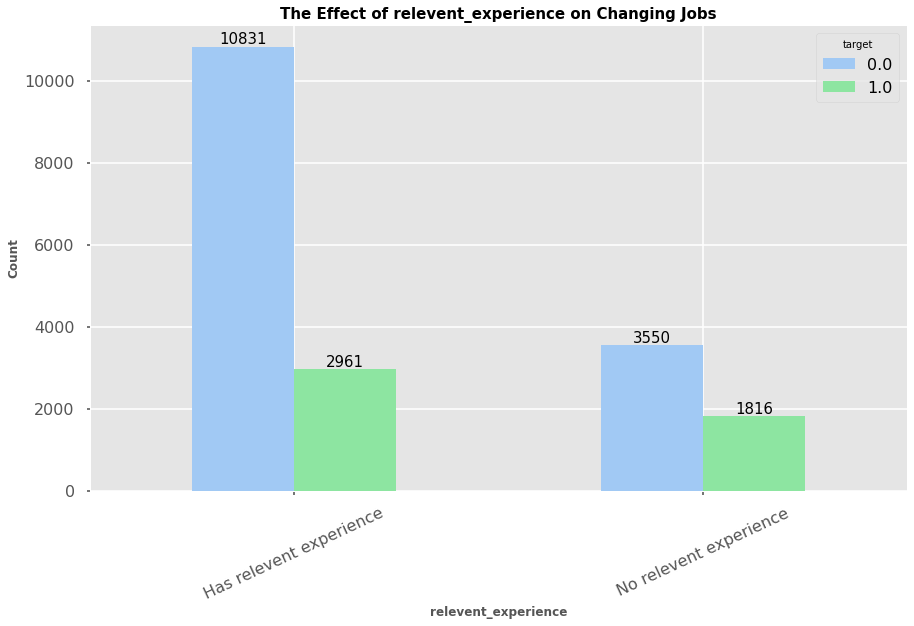

In [14]:
get_ct_graph('relevent_experience')

- Most job changes are done by workers with relevant experience

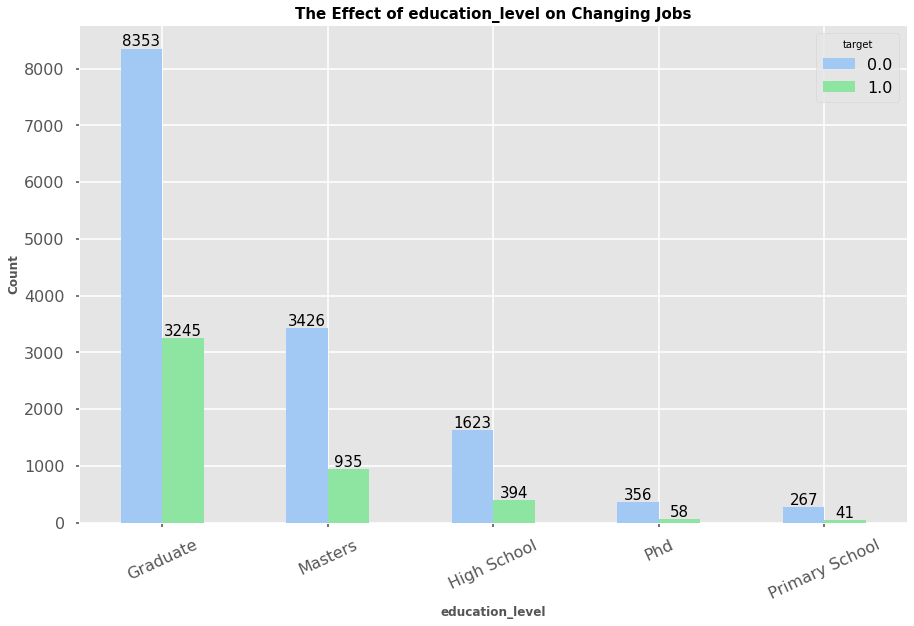

In [15]:
get_ct_graph('education_level')

- Most job changes are done by college/univeristy graduates

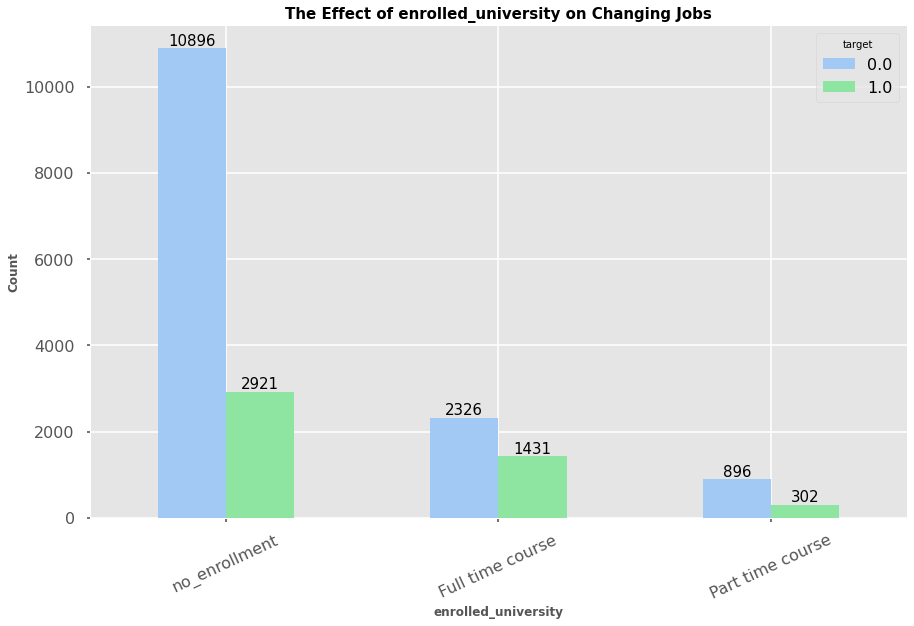

In [16]:
get_ct_graph('enrolled_university')

- Most job changes are done by workers who are not enrolled in university

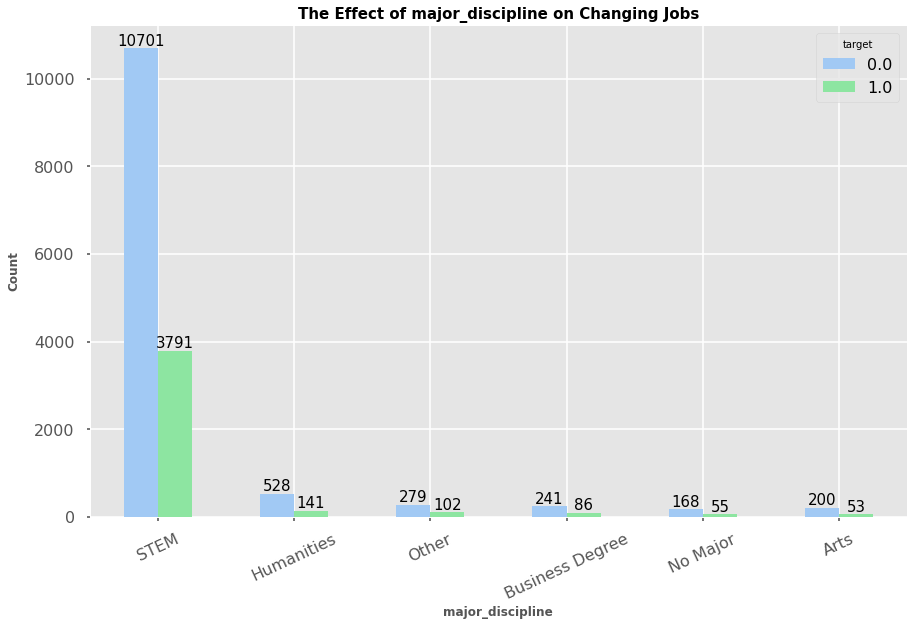

In [17]:
get_ct_graph('major_discipline')

- Most job changes are done by those workers who a degree in a STEM field

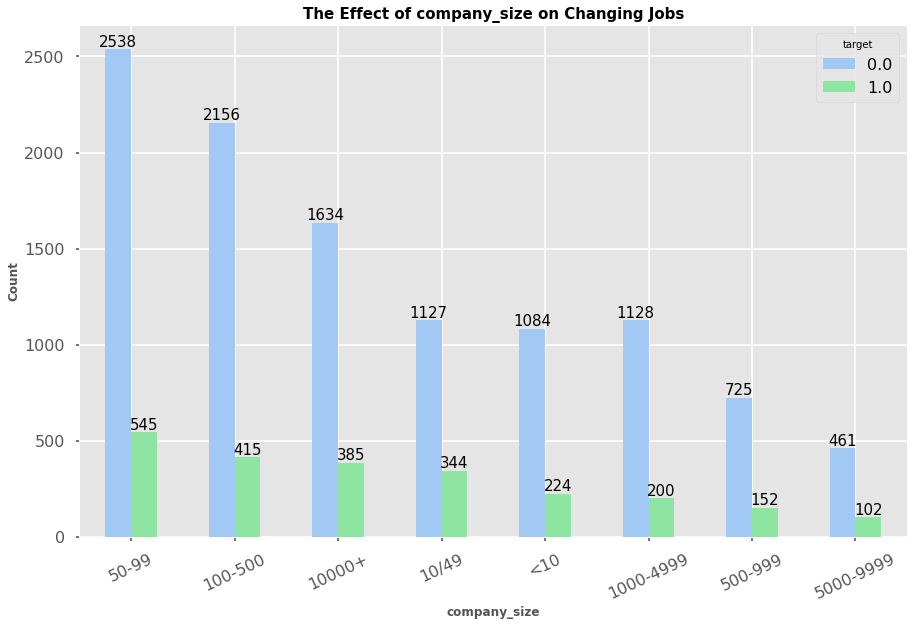

In [18]:
get_ct_graph('company_size')

- Most job changes occur at companies between 50-99 employees, however companies with 100-500 employees are not far behind

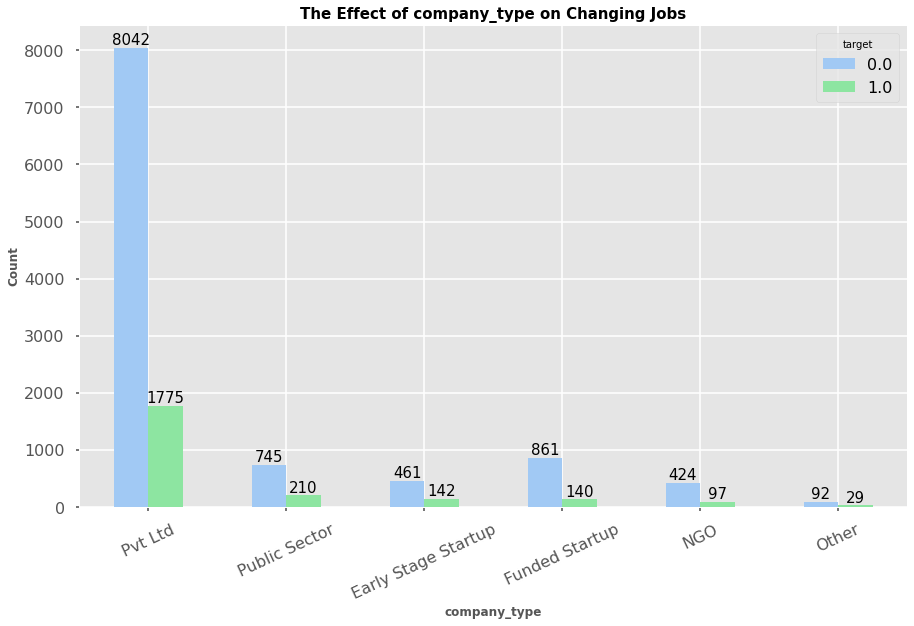

In [19]:
get_ct_graph('company_type')

- Most job changes occur at comapnies which are Pvt Ltd (Private Limited)

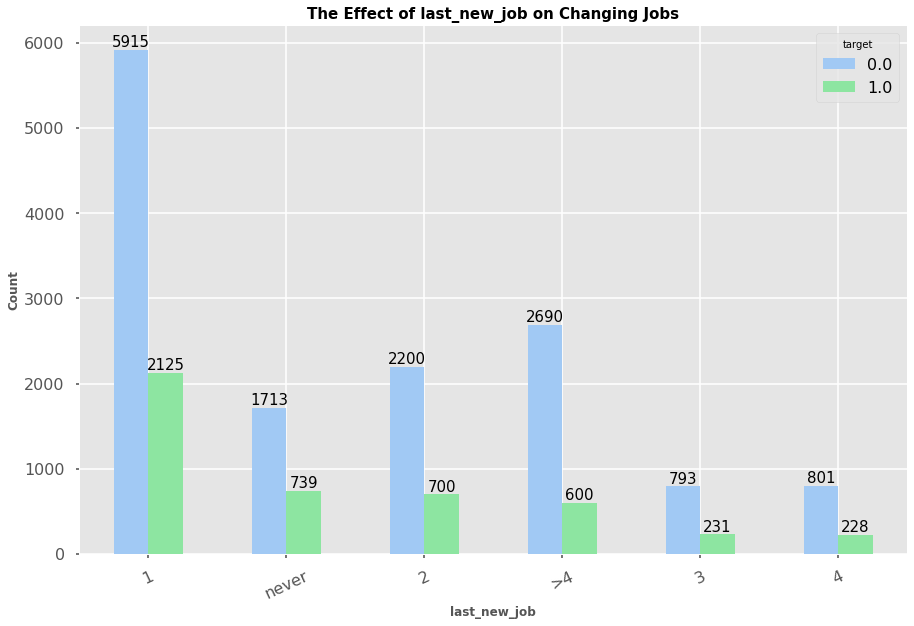

In [20]:
get_ct_graph('last_new_job')

- Most workers who change job have been at their previous for only a year

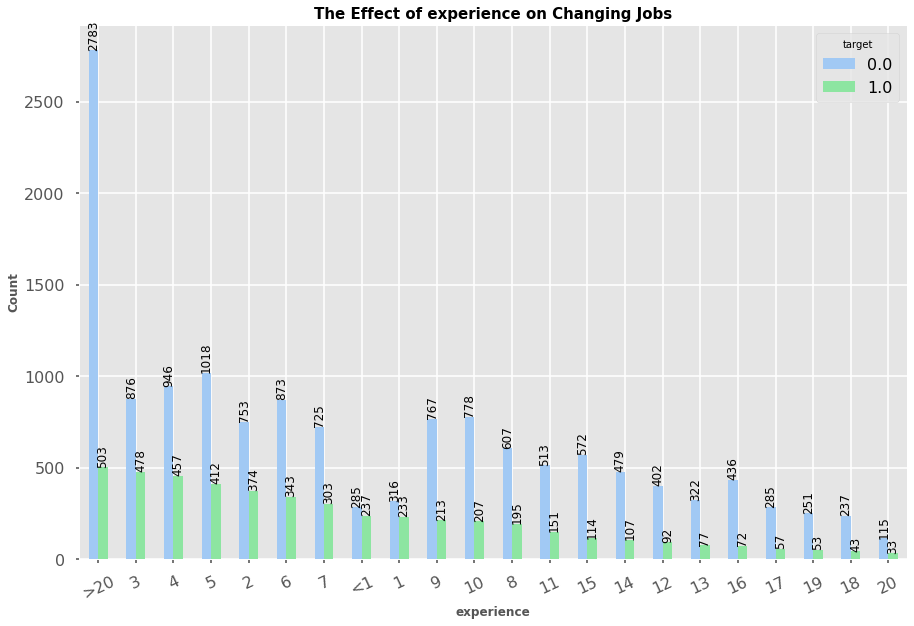

In [21]:
get_ct_graph('experience','vertical',12)

- Those with over 20 years of experience make up the segment with the most job chages

#### The previous 8 graphs showed the relationship between each of those features and changing jobs

In [22]:
train['training_hours'].describe()

count    19158.000000
mean        65.366896
std         60.058462
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64

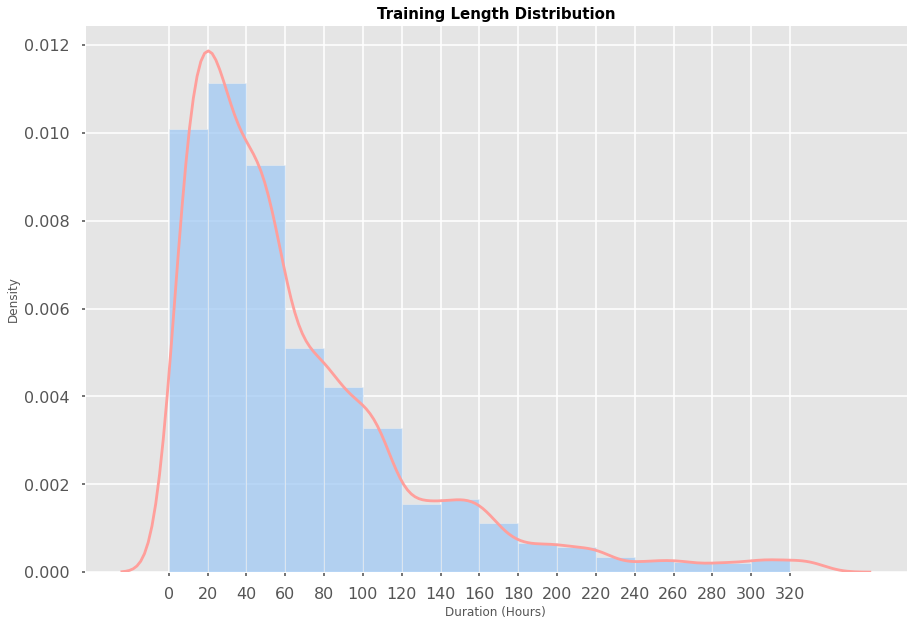

In [23]:
sns.histplot(data=train,x='training_hours',bins=np.arange(0,340,20),stat='density',color=palette[0])
sns.kdeplot(data=train['training_hours'],color=palette[3])
plt.xticks(ticks=np.arange(0,340,20))
plt.xlabel('Duration (Hours)')
plt.title('Training Length Distribution',fontsize=15,fontweight='bold')
plt.tight_layout()

- Most workers have completed 20-40 hours of training, while some have also completed well over 100 hours of training

<AxesSubplot:xlabel='training_hours'>

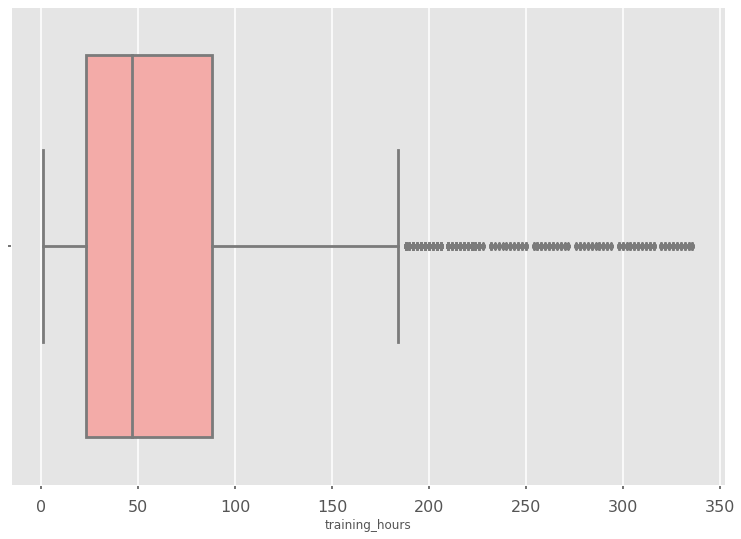

In [24]:
sns.boxplot(x=train['training_hours'],color=palette[3])

- Visualizing the outliers in this column, we can see there are many

In [25]:
th_q1,th_q3 = 23, 88
th_iqr = th_q3-th_q1
th_lower, th_upper = (th_q1 - 1.5*(th_iqr)), (th_q3 + 1.5*(th_iqr))
th_outliers = train[(train['training_hours']>th_upper)| (train['training_hours']<th_lower)]
th_outliers.shape

(984, 14)

- We can see we have 984 outliers in the training_hours column.
- We will test models with and without outliers for accuracy and assessing over/underfitting

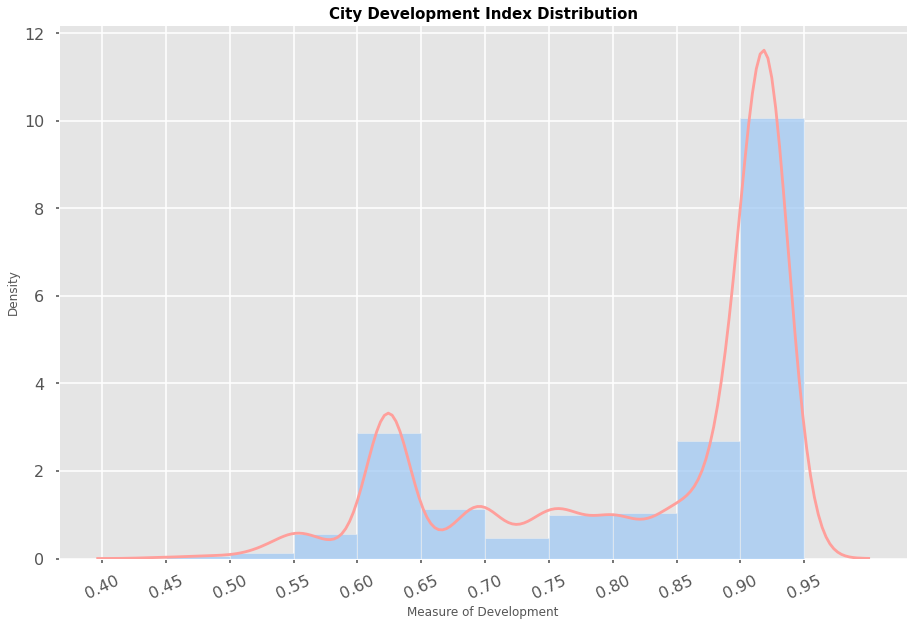

In [26]:
sns.histplot(data=train,x='city_development_index',bins=np.arange(0.4,1,.05),stat='density',color=palette[0])
sns.kdeplot(data=train['city_development_index'],color=palette[3])
plt.xticks(ticks=np.arange(0.4,1,.05),rotation=25)
plt.xlabel('Measure of Development')
plt.title('City Development Index Distribution',fontsize=15,fontweight='bold')
plt.tight_layout()

- We can see most cities have a development index between 0.9 - 0.95, while there is an interestingly high level between 0.6 - 0.65 relative to the other bins.

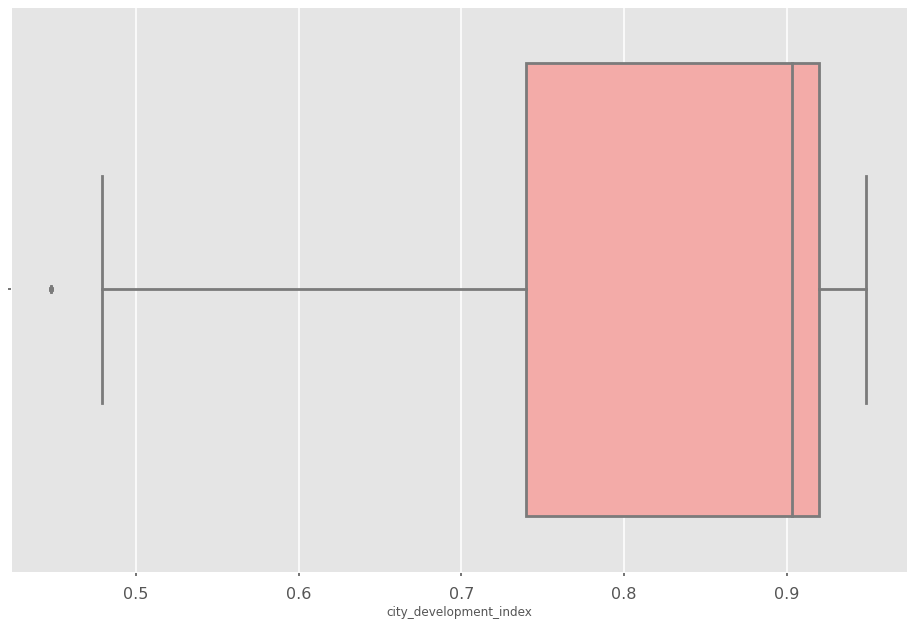

In [27]:
sns.boxplot(x=train['city_development_index'],color=palette[3])
plt.tight_layout()

In [28]:
cdi_q1,cdi_q3 = .74, .92
cdi_iqr = cdi_q3-cdi_q1
cdi_lower, cdi_upper = (cdi_q1 - 1.5*(cdi_iqr)), (cdi_q3 + 1.5*(cdi_iqr))
cdi_outliers = train[(train['city_development_index']>cdi_upper)| (train['city_development_index']<cdi_lower)]
cdi_outliers.shape

(17, 14)

- We can see we don't have too many outliers for this column (only 17)

In [29]:
cdi_outliers

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1523,8238,city_33,0.448,NaN,Has relevent experience,Part time course,Graduate,STEM,10,50-99,NGO,>4,48,1.0
4744,30985,city_33,0.448,NaN,No relevent experience,Full time course,Graduate,STEM,2,NaN,NaN,never,43,1.0
5010,27970,city_33,0.448,Male,No relevent experience,no_enrollment,Graduate,STEM,1,NaN,NaN,never,73,1.0
5265,31194,city_33,0.448,NaN,No relevent experience,NaN,High School,NaN,5,NaN,Pvt Ltd,never,86,1.0
5567,598,city_33,0.448,NaN,Has relevent experience,Part time course,Masters,STEM,6,NaN,NaN,1,18,1.0
6127,18564,city_33,0.448,NaN,No relevent experience,Full time course,Graduate,STEM,4,NaN,Public Sector,4,32,1.0
7724,31179,city_33,0.448,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,28,0.0
7864,26838,city_33,0.448,Male,Has relevent experience,no_enrollment,Graduate,STEM,8,NaN,NaN,>4,74,0.0
9134,4858,city_33,0.448,NaN,No relevent experience,Part time course,Masters,Other,2,<10,NGO,1,23,1.0
10401,19463,city_33,0.448,Male,No relevent experience,no_enrollment,Graduate,STEM,5,10000+,Pvt Ltd,2,36,0.0


- Taking a closer look it seems these 17 entries are all for city_33, so we will leave this data in as removing this data would remove data from this city entirely

### Preparing the data for models

#### Ordinal encoding for the following columns

In [30]:
print(train['relevent_experience'].unique())
print(train['company_size'].unique())
print(train['education_level'].unique())
print(train['last_new_job'].unique())
print(train['experience'].unique())

['Has relevent experience' 'No relevent experience']
[nan '50-99' '<10' '10000+' '5000-9999' '1000-4999' '10/49' '100-500'
 '500-999']
['Graduate' 'Masters' 'High School' nan 'Phd' 'Primary School']
['1' '>4' 'never' '4' '3' '2' nan]
['>20' '15' '5' '<1' '11' '13' '7' '17' '2' '16' '1' '4' '10' '14' '18'
 '19' '12' '3' '6' '9' '8' '20' nan]


In [31]:
train.relevent_experience = train.relevent_experience.map({'No relevent experience':0,
                                                           'Has relevent experience':1})
train.company_size = train.company_size.map({'<10':0,'10/49':1,'50-99':2,'100-500':3,'500-999':4,'1000-4999':5,
                                             '5000-9999':6,'10000+':7})
train.education_level = train.education_level.map({'Primary School':0,'High School':1,'Graduate':2,'Masters':3,
                                                  'Phd':4})
train.last_new_job = train.last_new_job.map({'never':0,'1':1,'2':2,'3':3,'4':4,'>4':5})
train.experience = train.experience.map({'<1':0,'1':1,'2':2,'3':3,'4':4,'5':5,'6':6,'7':7,'8':8,'9':9,'10':10,
                                        '11':11,'12':12,'13':13,'14':14,'15':15,'16':16,'17':17,'18':18,
                                        '19':19,'20':20,'>20':21})

In [32]:
print(train['gender'].nunique())
print(train['enrolled_university'].nunique())
print(train['city'].nunique())
print(train['major_discipline'].nunique())
print(train['company_type'].nunique())

3
3
123
6
6


#### The values in these columns will be prepared for models using get_dummies

In [33]:
train=pd.get_dummies(data=train,columns=['gender','enrolled_university','major_discipline','company_type',
                                         'city'],prefix=['g','uni','major','type','c'])

In [34]:
train.drop(columns=['enrollee_id'],inplace=True)
train.head()

,city_development_index,relevent_experience,education_level,experience,company_size,last_new_job,training_hours,target,g_Female,g_Male,...,c_city_84,c_city_89,c_city_9,c_city_90,c_city_91,c_city_93,c_city_94,c_city_97,c_city_98,c_city_99
0,0.920,1,2.0,21.0,NaN,1.0,36,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.776,0,2.0,15.0,2.0,5.0,47,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.624,0,2.0,5.0,NaN,0.0,83,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.789,0,2.0,0.0,NaN,0.0,52,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.767,1,3.0,21.0,2.0,4.0,8,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [35]:
no_th_outliers = train[(train['training_hours']<th_upper)& (train['training_hours']>th_lower)]

In [36]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train[['city_development_index','training_hours']] = scaler.fit_transform(train[['city_development_index','training_hours']].astype(np.float64))

- Scaling the columns for the CDI and training hours using MinMaxScaler from SK-Learn

In [37]:
train.head()

,city_development_index,relevent_experience,education_level,experience,company_size,last_new_job,training_hours,target,g_Female,g_Male,...,c_city_84,c_city_89,c_city_9,c_city_90,c_city_91,c_city_93,c_city_94,c_city_97,c_city_98,c_city_99
0,0.942116,1,2.0,21.0,NaN,1.0,0.104478,1.0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.654691,0,2.0,15.0,2.0,5.0,0.137313,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.351297,0,2.0,5.0,NaN,0.0,0.244776,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.680639,0,2.0,0.0,NaN,0.0,0.152239,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.636727,1,3.0,21.0,2.0,4.0,0.020896,0.0,0,1,...,0,0,0,0,0,0,0,0,0,0


#### Importing libraries for modelling

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,plot_confusion_matrix,auc
from sklearn.metrics import balanced_accuracy_score,roc_auc_score,make_scorer,roc_curve,precision_recall_curve
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from xgboost import plot_importance

In [39]:
X = train.drop(columns=['target'])
y = train['target']

In [40]:
sum(y)/len(y)

0.24934753105752167

- We can see that around 25% of workers change their jobs. So when we split the data into train and tests we will use stratify to make sure the same pecantage of people who change their jobs are in both sets.

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=27,stratify=y)

In [42]:
print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

0.24937360801781738
0.24926931106471817


- We can see that stratify worked as intended

In [43]:
base_model = xgb.XGBClassifier(objective='binary:logistic',missing=None,random_state=27,n_jobs=1, 
                          use_label_encoder=False)
base_model.fit(X_train,y_train,verbose=True,early_stopping_rounds=25,eval_metric='aucpr',eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.53782
[1]	validation_0-aucpr:0.55407
[2]	validation_0-aucpr:0.55241
[3]	validation_0-aucpr:0.55489
[4]	validation_0-aucpr:0.55661
[5]	validation_0-aucpr:0.55010
[6]	validation_0-aucpr:0.55007
[7]	validation_0-aucpr:0.54878
[8]	validation_0-aucpr:0.55208
[9]	validation_0-aucpr:0.55270
[10]	validation_0-aucpr:0.55492
[11]	validation_0-aucpr:0.55440
[12]	validation_0-aucpr:0.55260
[13]	validation_0-aucpr:0.55181
[14]	validation_0-aucpr:0.55316
[15]	validation_0-aucpr:0.55198
[16]	validation_0-aucpr:0.55112
[17]	validation_0-aucpr:0.54624
[18]	validation_0-aucpr:0.55006
[19]	validation_0-aucpr:0.54960
[20]	validation_0-aucpr:0.54741
[21]	validation_0-aucpr:0.54775
[22]	validation_0-aucpr:0.54616
[23]	validation_0-aucpr:0.54655
[24]	validation_0-aucpr:0.54745
[25]	validation_0-aucpr:0.54572
[26]	validation_0-aucpr:0.54392
[27]	validation_0-aucpr:0.54356
[28]	validation_0-aucpr:0.54419


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

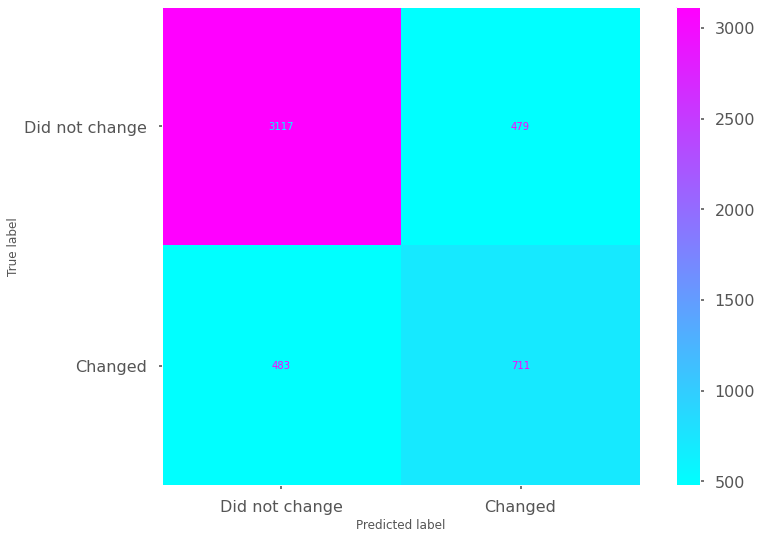

In [44]:
plot_confusion_matrix(base_model,X_test,y_test,display_labels=['Did not change','Changed'],cmap='cool')
plt.grid(False)

In this base model, we can see in the confusion matrix that of the 3,596 people that did not change their jobs, 3,117(87%) were correctly classified; and of the 1,194 people that did change their jobs, 711(59%) were correctly classified. So this base model wasn't that great, and that is most likely due to the imbalance of people who did change their i comparison to those who didn't. Because we want to predict people that will leave, XGBoost has a parameter called scaled_pos_weight, that will help in dealing with this imbalance. Using gridsearch cross validation we will tune the hyperparameters to achieve a more usefull model.

In [45]:
base_predictions = base_model.predict_proba(X_test)
base_probs = base_predictions[:,1]
base_d_model = DummyClassifier(strategy='stratified')
base_d_model.fit(X_train,y_train)
base_d_yhat = base_d_model.predict_proba(X_test)
base_d_probs = base_d_yhat[:,1]

### Optimizing Parameters using GridSearch and Cross Validation

In [46]:
param_grid0 = {'max_depth':[4,5,6],
              'learning_rate':[.01,.25,.05],
              'gamma':[0,0.25,0.5],
              'reg_lambda':[0,1,10],
              'scale_pos_weight':[3], #count(negative instances)/count(positive instances), so 3 should be the optimal value
              'subsample': [.9],
              'colsample_bytree':[0.4,0.5,0.6],}
params = GridSearchCV(estimator=base_model,param_grid=param_grid0,scoring='roc_auc',verbose=1,n_jobs=10,cv=5)

In [ ]:
params.fit(X_train,y_train,early_stopping_rounds=25,eval_metric='auc',eval_set=[(X_test,y_test)])

In [ ]:
print(params.best_params_)

- The best parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 10, 'scale_pos_weight': 3, 'subsample': 0.9}

In [ ]:
param_grid1 = {'colsample_bytree': [0.5], 
               'gamma': [0], 
               'learning_rate': [0.05,.075,.1], 
               'max_depth': [6,7,8], 
               'reg_lambda': [10,11,12], 
               'scale_pos_weight': [3], 
               'subsample': [0.9]}
params1 = GridSearchCV(estimator=base_model,param_grid=param_grid1,scoring='roc_auc',verbose=1,n_jobs=10,cv=5)
params1.fit(X_train,y_train,early_stopping_rounds=25,eval_metric='auc',eval_set=[(X_test,y_test)])

In [ ]:
print(params1.best_params_)

- The best parameters: {'colsample_bytree': 0.5, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 10, 'scale_pos_weight': 3, 'subsample': 0.9}

In [47]:
opt_model = xgb.XGBClassifier(objective = 'binary:logistic',missing = None,random_state = 27,n_jobs = 1, 
                              use_label_encoder = False,colsample_bytree = 0.5, gamma = 0, 
                              learning_rate = 0.05, max_depth = 6, reg_lambda = 10, scale_pos_weight = 3, 
                              subsample = 0.9)
opt_model.fit(X_train,y_train,verbose=True,early_stopping_rounds=25,eval_metric='aucpr',
              eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.39788
[1]	validation_0-aucpr:0.40145
[2]	validation_0-aucpr:0.41088
[3]	validation_0-aucpr:0.50233
[4]	validation_0-aucpr:0.50667
[5]	validation_0-aucpr:0.52371
[6]	validation_0-aucpr:0.53663
[7]	validation_0-aucpr:0.54055
[8]	validation_0-aucpr:0.54338
[9]	validation_0-aucpr:0.54298
[10]	validation_0-aucpr:0.54379
[11]	validation_0-aucpr:0.54582
[12]	validation_0-aucpr:0.54717
[13]	validation_0-aucpr:0.54871
[14]	validation_0-aucpr:0.54902
[15]	validation_0-aucpr:0.54996
[16]	validation_0-aucpr:0.55042
[17]	validation_0-aucpr:0.55003
[18]	validation_0-aucpr:0.55081
[19]	validation_0-aucpr:0.55076
[20]	validation_0-aucpr:0.55053
[21]	validation_0-aucpr:0.55040
[22]	validation_0-aucpr:0.55015
[23]	validation_0-aucpr:0.55036
[24]	validation_0-aucpr:0.54953
[25]	validation_0-aucpr:0.54835
[26]	validation_0-aucpr:0.54860
[27]	validation_0-aucpr:0.54965
[28]	validation_0-aucpr:0.54873
[29]	validation_0-aucpr:0.54814
[30]	validation_0-aucpr:0.54852
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=10, scale_pos_weight=3, subsample=0.9,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

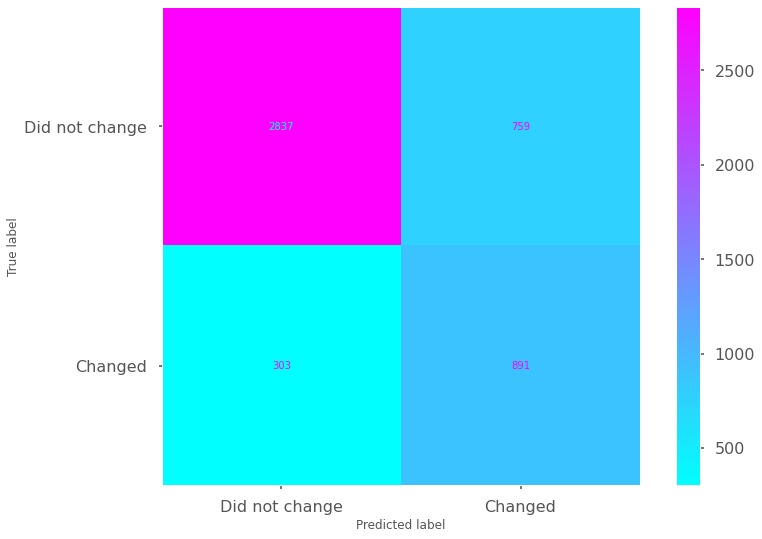

In [48]:
plot_confusion_matrix(opt_model,X_test,y_test,display_labels=['Did not change','Changed'],cmap='cool')
plt.grid(False)

We can see with the new optimized model, that we have increased our accuracy of classfiying those who change their jobs from around 59% to 75% which is a significant improvement. However, this comes at a cost to an increase in wrongly classifying those who did not change their jobs, with our base model we had an accuracy of 87% where now we have gone down to 80%. However, in this case I will assume that correctly classifying those who change is more important than lsing some accuracy in classifying those who did not leave. 

In [49]:
yhat = opt_model.predict(X_test)
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

         0.0       0.90      0.79      0.84      3596
         1.0       0.54      0.75      0.63      1194

    accuracy                           0.78      4790
   macro avg       0.72      0.77      0.73      4790
weighted avg       0.81      0.78      0.79      4790



In [50]:
predictions = opt_model.predict_proba(X_test)
probs = predictions[:,1]
d_model = DummyClassifier(strategy='stratified')
d_model.fit(X_train,y_train)
d_yhat = d_model.predict_proba(X_test)
d_probs = d_yhat[:,1]

### Using dataframe with removed outliers from training hours column

In [53]:
no_th_outliers.loc[:,['city_development_index','training_hours']]

,city_development_index,training_hours
0,0.942116,0.191257
1,0.654691,0.251366
2,0.351297,0.448087
3,0.680639,0.278689
4,0.636727,0.038251
...,...,...
19153,0.858283,0.224044
19154,0.942116,0.278689
19155,0.942116,0.234973
19156,0.706587,0.524590


In [52]:
no_th_outliers.loc[:,['city_development_index','training_hours']] = scaler.fit_transform(no_th_outliers.loc[:,['city_development_index','training_hours']].astype(np.float64))

/Users/ibrahimwasti/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [54]:
X1 = no_th_outliers.drop(columns=['target'])
y1 = no_th_outliers['target']
sum(y1)/len(y1)

0.2512930560140861

In [55]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1,y1,random_state=27,stratify=y1)

In [56]:
print(sum(y_train1)/len(y_train1))
print(sum(y_test1)/len(y_test1))

0.2512839325018342
0.25132042253521125


In [57]:
model1 = xgb.XGBClassifier(objective = 'binary:logistic',missing = None,random_state = 27,n_jobs = 1, 
                              use_label_encoder = False)

In [58]:
outlier_param_grid0 = {'max_depth':[4,5,6],
              'learning_rate':[.01,.25,.05],
              'gamma':[0,0.25,0.5],
              'reg_lambda':[0,1,10],
              'scale_pos_weight':[2.5,3,3.5], #count(negative instances)/count(positive instances)
              'subsample': [.9],
              'colsample_bytree':[0.4,0.5,0.6],}
outlier_params = GridSearchCV(estimator=model1,param_grid=outlier_param_grid0,scoring='roc_auc',verbose=1,n_jobs=10,cv=5)

In [ ]:
outlier_params.fit(X_train,y_train,early_stopping_rounds=25,eval_metric='auc',eval_set=[(X_test,y_test)])

In [ ]:
print(outlier_params.best_params_)

- The best parameters: {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 6, 'reg_lambda': 10, 'scale_pos_weight': 2.5, 'subsample': 0.9}

In [ ]:
outlier_params_grid1 = {'max_depth':[6,7,8],
              'learning_rate':[.05,.075,.1],
              'gamma':[0.5,.75,1],
              'reg_lambda':[10,15,20],
              'scale_pos_weight':[2,2.25,2.5],
              'subsample': [.9],
              'colsample_bytree':[0.5],}
outlier_params1 = GridSearchCV(estimator=model1,param_grid=outlier_params_grid1,scoring='roc_auc',verbose=1,n_jobs=10,cv=5)

In [ ]:
outlier_params1.fit(X_train,y_train,early_stopping_rounds=25,eval_metric='auc',eval_set=[(X_test,y_test)])

In [ ]:
print(outlier_params1.best_params_)

- The best parameters: {'colsample_bytree': 0.5, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 7, 'reg_lambda': 15, 'scale_pos_weight': 2.5, 'subsample': 0.9}

In [59]:
opt_model1 = xgb.XGBClassifier(objective = 'binary:logistic',missing = None,random_state = 27,n_jobs = 1, 
                              use_label_encoder = False,colsample_bytree = 0.5, gamma = 0.5, 
                              learning_rate = 0.05, max_depth = 7, reg_lambda = 15, scale_pos_weight = 2.75, 
                              subsample = 0.9)
opt_model1.fit(X_train1,y_train1,verbose=True,early_stopping_rounds=25,eval_metric='aucpr',eval_set=[(X_test1,y_test1)])

[0]	validation_0-aucpr:0.39685
[1]	validation_0-aucpr:0.51173
[2]	validation_0-aucpr:0.55253
[3]	validation_0-aucpr:0.56277
[4]	validation_0-aucpr:0.56321
[5]	validation_0-aucpr:0.56414
[6]	validation_0-aucpr:0.56493
[7]	validation_0-aucpr:0.56075
[8]	validation_0-aucpr:0.56353
[9]	validation_0-aucpr:0.56519
[10]	validation_0-aucpr:0.56114
[11]	validation_0-aucpr:0.56006
[12]	validation_0-aucpr:0.55973
[13]	validation_0-aucpr:0.56042
[14]	validation_0-aucpr:0.55933
[15]	validation_0-aucpr:0.55918
[16]	validation_0-aucpr:0.55929
[17]	validation_0-aucpr:0.55996
[18]	validation_0-aucpr:0.56091
[19]	validation_0-aucpr:0.55974
[20]	validation_0-aucpr:0.55953
[21]	validation_0-aucpr:0.55782
[22]	validation_0-aucpr:0.55865
[23]	validation_0-aucpr:0.55732
[24]	validation_0-aucpr:0.55749
[25]	validation_0-aucpr:0.55759
[26]	validation_0-aucpr:0.55822
[27]	validation_0-aucpr:0.55913
[28]	validation_0-aucpr:0.55936
[29]	validation_0-aucpr:0.55888
[30]	validation_0-aucpr:0.56060
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, monotone_constraints='()',
              n_estimators=100, n_jobs=1, num_parallel_tree=1, random_state=27,
              reg_alpha=0, reg_lambda=15, scale_pos_weight=2.75, subsample=0.9,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

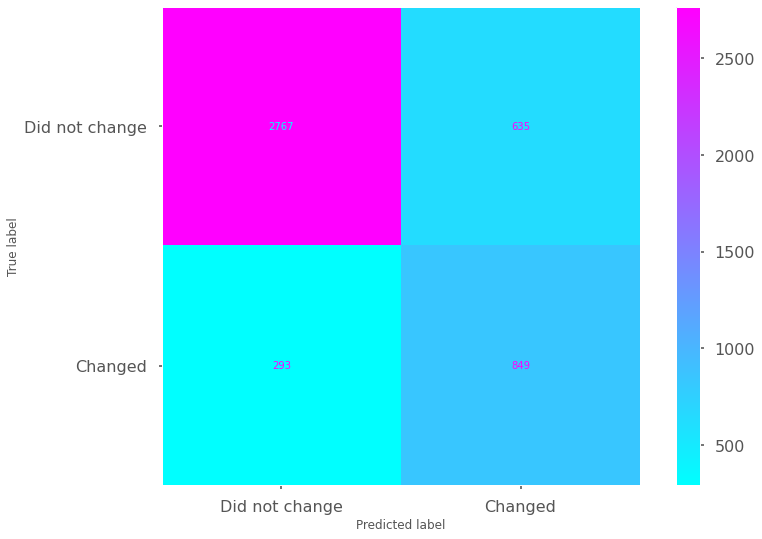

In [60]:
plot_confusion_matrix(opt_model1,X_test1,y_test1,display_labels=['Did not change','Changed'],cmap='cool')
plt.grid(False)

We can see using the best parameter grid from the pervious model, this model correctly classified 74% of those who changed their jobs which is the same as our optimized model with the outliers included; it also correctly classified 82% of those who did not change their jobs. We can see there was a slight decrease in classifying those who did change their jobs and a slight increase in classifying those who did not.

In [61]:
yhat1 = opt_model1.predict(X_test1)
print(classification_report(y_test1,yhat1))

              precision    recall  f1-score   support

         0.0       0.90      0.81      0.86      3402
         1.0       0.57      0.74      0.65      1142

    accuracy                           0.80      4544
   macro avg       0.74      0.78      0.75      4544
weighted avg       0.82      0.80      0.80      4544



In [62]:
predictions1 = opt_model1.predict_proba(X_test1)
probs1 = predictions1[:,1]
d_model = DummyClassifier(strategy='stratified')
d_model.fit(X_train1,y_train1)
d_yhat = d_model.predict_proba(X_test1)
d_probs1 = d_yhat[:,1]

Both the optimized model with and without outliers performed significantly better than the base model, however we can see the model trained without the outliers performed better than .

In [63]:
def plot_roc_auc(d_probs,model_probs,y_test=y_test,c=palette[0],outliers=''):
    fpr, tpr, _ = roc_curve(y_test,d_probs)
    plt.plot(fpr,tpr,linestyle='--',label='No Skill ' + str(outliers))
    fpr,tpr,_ = roc_curve(y_test,model_probs)
    plt.plot(fpr,tpr,marker='_',color=c,label='Opt Model ' + str(outliers))
    plt.xlabel('False Positive Rate',fontsize=13,fontweight='bold')
    plt.ylabel('True Positive Rate',fontsize=13,fontweight='bold')
    plt.title('ROC Curve',fontsize = 15, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    roc_auc = roc_auc_score(y_test,d_probs)
    print('No Skill ' + str(outliers) + ' ROC AUC Score: %.3f' %roc_auc)
    roc_auc = roc_auc_score(y_test,model_probs)
    print('Opt Model ' + str(outliers) + ' Score: %.3f' %roc_auc)

No Skill w/ Outliers ROC AUC Score: 0.507
Opt Model w/ Outliers Score: 0.798
No Skill w/o Outliers ROC AUC Score: 0.501
Opt Model w/o Outliers Score: 0.812


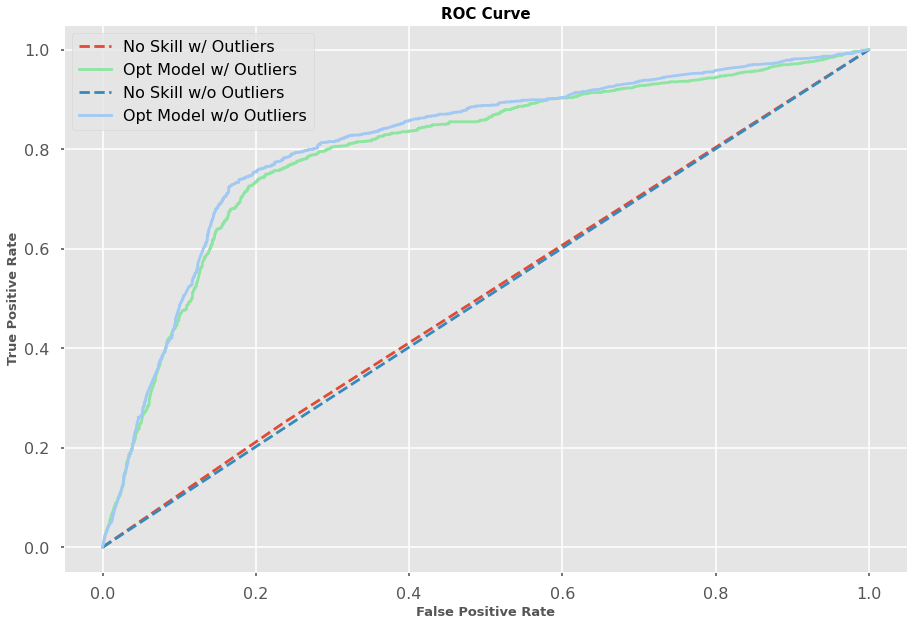

In [64]:
plot_roc_auc(d_probs,probs,c=palette[2],outliers='w/ Outliers')
plot_roc_auc(d_probs1,probs1,y_test1,outliers='w/o Outliers')

In [65]:
def plot_pr_curve(model_probs,d_probs=d_probs,y_test=y_test,c=palette[0],outliers=''):
    precision, recall, _ = precision_recall_curve(y_test,d_probs)
    auc_score=auc(recall,precision)
    print('No Skill ' + str(outliers) + ' PR AUC: %.3f' %auc_score)
    no_skill = len(y_test[y_test==1])/len(y_test)
    plt.plot([0,1],[no_skill,no_skill],linestyle='--',label='No Skill ' + str(outliers))
    precision, recall, _ = precision_recall_curve(y_test,model_probs)
    plt.plot(recall, precision, marker='_',color=c,label='Opt Model ' + str(outliers))
    plt.xlabel('Recall',fontsize=13,fontweight='bold')
    plt.ylabel('Precision',fontsize=13,fontweight='bold')
    plt.title('Precision Recall Curve',fontsize = 15, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    auc_score = auc(recall,precision)
    print('Model ' + str(outliers) + ' PR AUC: %.3f' %auc_score)

No Skill w/ outliers PR AUC: 0.349
Model w/ outliers PR AUC: 0.551
No Skill w/o Outliers PR AUC: 0.348
Model w/o Outliers PR AUC: 0.569


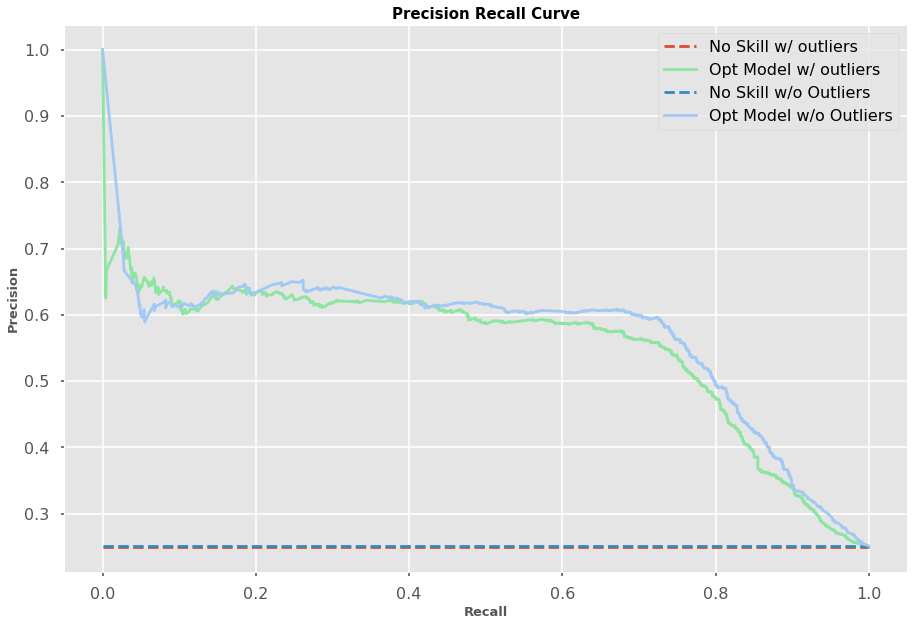

In [66]:
plot_pr_curve(probs,c=palette[2],outliers='w/ outliers')
plot_pr_curve(probs1,d_probs1,y_test1,outliers='w/o Outliers')